# Covariance Estimation & Option Portfolio VaR


## Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")

from risk_analysis.data import load_price_history, compute_log_returns
from risk_analysis.shrinkage import constant_correlation_shrinkage, single_index_shrinkage
from risk_analysis.options import (
    OptionContract,
    option_portfolio_valuation,
    simulate_option_var,
)

%matplotlib inline

## Load market data

In [2]:
PROJECT_ROOT = Path.cwd().resolve().parent
dataset = pd.read_csv(PROJECT_ROOT / 'q4_dataset.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
stock_prices = dataset.iloc[:, :-1]
market_prices = dataset.iloc[:, -1]

stock_log_returns = np.log(stock_prices).diff().dropna()
market_log_returns = np.log(market_prices).diff().dropna()
stock_log_returns.head()

,AA,INTC,JPM,PG
Date,,,,
2022-02-23,0.016465,-0.000895,-0.021161,-0.012552
2022-02-24,-0.027185,0.045318,-0.028238,-0.027299
2022-02-25,0.060223,0.020969,0.023384,0.041813
2022-02-28,-0.032773,-0.000210,-0.042592,-0.014962
2022-03-01,0.057262,-0.018621,-0.038460,-0.016689


## Covariance estimators

In [3]:
sample_cov = stock_log_returns.cov()
ledoit_cov, lw_shrink = constant_correlation_shrinkage(stock_log_returns)

# Build single-index prior and shrinkage matrix
si_cov, si_shrink = single_index_shrinkage(stock_log_returns, market_log_returns)

print('Ledoit-Wolf shrinkage intensity:', lw_shrink)
print('Single-index shrinkage intensity:', si_shrink)
ledoit_cov

Ledoit-Wolf shrinkage intensity: 0.41662655146710725
Single-index shrinkage intensity: 0.5320733987930313


,AA,INTC,JPM,PG
AA,0.001406,0.000295,0.000224,0.000108
INTC,0.000295,0.000604,0.000133,0.000090
JPM,0.000224,0.000133,0.000242,0.000062
PG,0.000108,0.000090,0.000062,0.000140


### Condition numbers

In [4]:
def condition_number(matrix):
    eigenvalues = np.linalg.eigvalsh(matrix)
    return float(eigenvalues.max() / eigenvalues.min())

print('Sample covariance CN:', condition_number(sample_cov))
print('Ledoit-Wolf covariance CN:', condition_number(ledoit_cov))
print('Single-index covariance CN:', condition_number(si_cov))

Sample covariance CN: 14.788552282020495
Ledoit-Wolf covariance CN: 14.453164594223942
Single-index covariance CN: 14.335306112211144


## Option portfolio

In [5]:
spot_prices = stock_prices.iloc[-1]
annual_vol = np.sqrt(sample_cov.values.diagonal() * 252)
contracts = [
    OptionContract('AA', 'call', 6, round(1.05 * spot_prices['AA']), 1.0),
    OptionContract('INTC', 'call', -3, round(0.90 * spot_prices['INTC']), 0.75),
    OptionContract('JPM', 'put', 6, round(spot_prices['JPM']), 0.5),
    OptionContract('PG', 'put', -2, round(1.10 * spot_prices['PG']), 0.75),
]
portfolio_values = option_portfolio_valuation(
    spot_prices,
    pd.Series(annual_vol, index=stock_prices.columns),
    contracts,
)
portfolio_values

,type,quantity,strike,maturity,option_value,position_value
ticker,,,,,,
AA,call,6.0,28.0,1.00,5.930440,35.582638
INTC,call,-3.0,40.0,0.75,8.566701,-25.700104
JPM,put,6.0,176.0,0.50,10.601381,63.608285
PG,put,-2.0,170.0,0.75,16.295867,-32.591733
Portfolio,NaN,NaN,NaN,NaN,NaN,40.899087


## VaR simulation

In [6]:
simulation = simulate_option_var(
    log_returns=stock_log_returns,
    spot_prices=spot_prices,
    contracts=contracts,
    horizon_days=10,
    confidence=0.99,
    n_bootstrap=5000,
)

bootstrap_var = simulation['bootstrap']['VaR']
bootstrap_es = simulation['bootstrap']['ES']
gaussian_var = simulation['gaussian']['VaR']
gaussian_es = simulation['gaussian']['ES']

print(f'Bootstrap VaR: {bootstrap_var:.2f}$')
print(f'Bootstrap ES: {bootstrap_es:.2f}$')
print(f'Gaussian VaR: {gaussian_var:.2f}$')
print(f'Gaussian ES: {gaussian_es:.2f}$')

Bootstrap VaR: 48.66$
Bootstrap ES: 55.03$
Gaussian VaR: 48.12$
Gaussian ES: 54.16$


### Portfolio P&L distribution

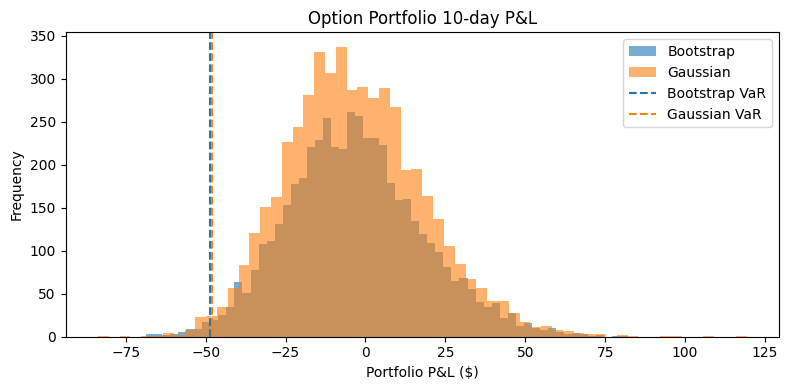

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(simulation['bootstrap']['portfolio_pnl'], bins=60, alpha=0.6, label='Bootstrap')
ax.hist(simulation['gaussian']['portfolio_pnl'], bins=60, alpha=0.6, label='Gaussian')
ax.axvline(-bootstrap_var, color='tab:blue', linestyle='--', label='Bootstrap VaR')
ax.axvline(-gaussian_var, color='tab:orange', linestyle='--', label='Gaussian VaR')
ax.set_xlabel('Portfolio P&L ($)')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_title('Option Portfolio 10-day P&L')
plt.tight_layout()